In [ ]:
git difftool --tool=b3 branch1..branch2

$ git diff > save.patch
$ patch -p1 < save.patch

$ git diff --no-prefix > save.patch
$ patch -p0 < save.patch


Rebase squash cherrypick automatically to create perfect feature branch?

Reset each file one at a time to make sure there aren't any unnecessary changes?

Use unit testing to warn about unnecessary modules?



In [ ]:
git log --graph --oneline --decorate --all

git log --graph --all

git show-branch --list

https://stackoverflow.com/questions/3515597/add-only-non-whitespace-changes
git diff -U0 -w --no-color | git apply --cached --ignore-whitespace --unidiff-zero -




Rename a bunch of files using Git and renamer?



In [1]:
var execSync = require('child_process').execSync;
try {
    require.resolve('renamer');
} catch (e) {
    execSync('npm install renamer');
}
var renamer = require('renamer');
var renameUsingGit = (gitRoot, match, find, replace) => {
    var files = renamer.expand(path.join(gitRoot, match));
    var results = renamer.replace({
        files: files.filesAndDirs, 
        find: find, 
        replace: replace});
    return renamer.dryRun(results).list.map(r => {
        // rename with git instead
        var output = execSync('git ' 
                 + '--work-tree=' + JSON.stringify(gitRoot)
                 + ' --git-dir=' + JSON.stringify(path.join(gitRoot, '.git'))
                 + ' mv ' + JSON.stringify(r.before) 
                 + ' ' + JSON.stringify(r.after));
        return output.toString() || r.after;
    });
};
renameUsingGit;


[Function: renameUsingGit]

In [2]:
// test it
// rename all scss files to less
//renameUsingGit(
//    '/Users/briancullinan/Documents/studysauce4',
//    'src/**/*.css',
//    '.css',
//    '.scss');


[ '/Users/briancullinan/Documents/studysauce4/src/app/account/account.component.scss',
  '/Users/briancullinan/Documents/studysauce4/src/app/account/contact-information/contact-information.component.scss',
  '/Users/briancullinan/Documents/studysauce4/src/app/account/payment/payment.component.scss',
  '/Users/briancullinan/Documents/studysauce4/src/app/account/switch-users/switch-users.component.scss',
  '/Users/briancullinan/Documents/studysauce4/src/app/activity/activity.component.scss',
  '/Users/briancullinan/Documents/studysauce4/src/app/cards/answer/answer.component.scss',
  '/Users/briancullinan/Documents/studysauce4/src/app/cards/audio-player.component.scss',
  '/Users/briancullinan/Documents/studysauce4/src/app/cards/card.component.scss',
  '/Users/briancullinan/Documents/studysauce4/src/app/cards/footer-count.component.scss',
  '/Users/briancullinan/Documents/studysauce4/src/app/cards/multiple/multiple.component.scss',
  '/Users/briancullinan/Documents/studysauce4/src/app/car

Create a json tree out of git?



In [2]:
var execSync = require('child_process').execSync;

var gitTree = (project) => {
    process.chdir(project)
    var branches = execSync('git branch --list --all ').toString()
        .trim().split(/\s*\n\s*\**\s*/ig)
        .map(b => b.replace('remotes/', '').trim());

    // reverse git so we can add merges to the "graph" after the branch tree is constructed
    var branch = execSync('git log --pretty=format:"%ct %d %h %p" '
                          + '--reverse --branches --remotes --tags ').toString().split(/\s*\n\s*/ig);
    var all = []; //execSync('git log --pretty=format:"%h %p" --reverse --all').toString().split(/\s*\n\s*/ig);

    var nodeTree = [];
    var edges = [];
    branch.forEach(b => {
        var commits = ((/[0-9]+\s+\(.*?\)\s*(.+)/ig).exec(b)
                       || (/[0-9]+\s+(.+)/ig).exec(b) || [b, b.trim()])[1].trim().split(/\s+/ig);
        commits.forEach(r => {
            if(nodeTree.filter(d => d.name==r).length == 0) {
                nodeTree[nodeTree.length] = {
                    name: r,
                    index: nodeTree.length,
                    branch: ((/[0-9]+\s+\((.*?)\)/ig).exec(b) || [b, ''])[1],
                    time: (/([0-9]+)\s+/ig).exec(b)[1]
                }
            }
        });
        // don't include merges in tree
        if(commits.length == 3) {
            commits = [commits[0], commits[2]];
        }
        if(commits.length == 2) {
            edges = edges.concat(commits.slice(1)
                                 // check all existing sources to test for merge
                                 .map((c, i) => {
                return {source: commits[i], target:c}; // -1 because of slice(1)
            }))
        }
    });

    var nodeMap = {};
    nodeTree.forEach(function(x) {
        if(typeof x.size == 'undefined') {
            x.size = 1;
        }
        nodeMap[x.name] = x;
    });

    edges.forEach(function(x) {
        if(typeof nodeMap[x.target].children == 'undefined') {
            nodeMap[x.target].children = [];
        }

        nodeMap[x.target].children.push(nodeMap[x.source]);
        // return { parent: nodeMap[x.target], source: nodeMap[x.source], target: nodeMap[x.target] };
    });
    edges.reverse().forEach(function(x) {
        if(typeof nodeMap[x.source].branch != 'undefined' && nodeMap[x.source].branch != ''
              && typeof nodeMap[x.target].branch == 'undefined' || nodeMap[x.target].branch == '') {
            nodeMap[x.target].branch = nodeMap[x.source].branch;
        }
    });
    return nodeTree;
}
module.exports = gitTree;
gitTree;



[Function: gitTree]

How to display git branches as a tree?



[ 'swiftpage/master',
  'swiftpage/B-11243_Proof_of_Concept_for_Angular_2.0_Portal, B-11243_Proof_of_Concept_for_Angular_2.0_Portal',
  'swiftpage/Bret_Portal_Deploy_config',
  'Universal',
  'swiftpage/development',
  'swiftpage/Only_auth',
  'swiftpage/B11309_APC_Direct_Purchase-Update_Preview_Api_Model',
  'swiftpage/B-11376_Account_Management_2',
  'B-11376_Account_Management_2',
  'swiftpage/B-11309_APC_Direct_Purchase-Fix_Signature_Issue',
  'B-11309_APC_Direct_Purchase',
  'Only_auth',
  'swiftpage/B-11309_APC_Direct_Purchase' ]


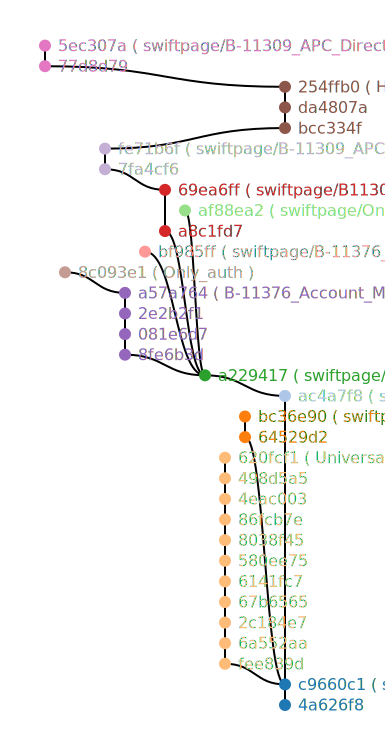

In [4]:
var D3Node = require('d3-node');
var d3n = new D3Node(); // initializes D3 with container element 
var d3 = d3n.d3;

var margin = {top: 25, right: 100, bottom: 25, left: 25},
    width = 960 - margin.left - margin.right,
    height = 500 - margin.top - margin.bottom;

var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;
var project = PROFILE_PATH + '/Documents/portal';

var nodeTree = gitTree(project);
var tree = d3.hierarchy(nodeTree[0], d => d.children);
var gitRoot = // partition(
    tree
        .sum(d => 1)
        .sort((a, b) => b.data.time - a.data.time || b.value - a.value)
//)
    .descendants();
var branches = gitRoot
    .map(r => r.data.branch.replace('HEAD -> ', '').trim())
    .filter((b, i, arr) => arr.indexOf(b) === i)

gitRoot.forEach(r => {
    r.name = r.data.name;
    r.index = r.data.index;
    r.branch = r.data.branch;
})

var tree = d3.tree().nodeSize([25, 150]);

var nodes = tree(d3.hierarchy(gitRoot[0], d => d.children))
    .descendants();

var links = nodes.slice(1);

var fill = d3.scaleOrdinal(d3.schemeCategory20);
var svg = d3n.createSVG(branches.length * 20 + margin.left + margin.right,
                       (nodeTree.length+1) * 20 + margin.top + margin.bottom)
var g = svg.append("g");

var x = d3.scaleLinear().range([branches.length * 20, 0]);
var y = d3.scaleLinear().range([(nodeTree.length+1) * 20, 0]);

x.domain([0, branches.length]);
y.domain([0, nodeTree.length]);

branchIndex = (d) => {
    var result = Math.min.apply(null, d.data.branch
                                       .split(/\s*,\s*/ig)
                                       .map(b => branches.indexOf(b))
                                       .filter(i => i > -1));
    if(!isFinite(result)) {
        result = 0;
    }
    return result;
};

g.selectAll('.link')
  .data(links)
  .enter().append('path')
    .attr('class', 'link')
    .attr('fill', 'none')
    .attr("stroke", "#000")
    .attr("stroke-width", 2)
    .attr('d', d => `
        M${x(branchIndex(d))},${y(d.data.index)}
        C${x((branchIndex(d) + branchIndex(d.parent)) / 2.0)},
          ${y(d.data.index)} ${x((branchIndex(d) + branchIndex(d.parent)) / 2.0)},
          ${y(d.parent.data.index)} ${x(branchIndex(d.parent))},
          ${y(d.parent.data.index)}`);

// Declare the nodes
var node = g.selectAll('g.node')
  .data(nodes)
  .enter().append('g')
  .attr('class', 'node')
  .style("fill", function(d, i) { return fill(d.data.branch); })
  .attr('transform', d => `translate(${x(branchIndex(d))},${y(d.data.index)})`);

node.append('circle')
  .attr('class', d => (d.data).isAux ? 'node-aux-route' : 'node-route')
  .attr('r', 6);

node.append('text')
  .attr('x', (d) => 13)
  .attr('dy', '.35em')
  .attr('text-anchor', 'start')
  .text(d => (d.data).name + (d.data.branch && (!d.data.children || d.data.children.filter(c => c.data.branch == d.data.branch) == 0) ? (' ( ' + d.data.branch + ' ) ') : ''))
  .attr('class', 'monospace');

// reset transform
g.attr('transform', 'translate(0, 0)');

g.attr("transform",
    "translate(" + (margin.left) + "," + (margin.top) + ")")

$$.svg(d3n.svgString());



Display graphs of different commands and scenarios using dry-run?

https://github.com/kpdecker/jsdiff

http://incaseofstairs.com/jsdiff/



In [ ]:
var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;
var project = typeof project === 'undefined' ? path.join(PROFILE_PATH, 'Documents/portal') : project;
var importer = require('../Core');

process.chdir(project)
var gulp = require('gulp');
var run = require('gulp-run');
var tap = require('gulp-tap');

gulp.task('git watch', function() {
    return run('git diff -w a229417..498d5a5')
        .pipe(tap(file => console.log(file)))
        .pipe(gulp.dest('output'));
});

var getBranchBoundaries = (p) => {
    project = p;
    return importer.interpretAll([
        'gulp task to a Promise'
    ])
    .then(r => r[0].runInNewContext({gulp}))
    .then(r => r(['git watch']))
}
module.exports = getBranchBoundaries;
getBranchBoundaries;

$$.async();
getBranchBoundaries(project)
    .then(r => $$.sendResult(r))
    .catch(e => $$.sendError(e));

